In [9]:
# Imports

import numpy as np
from sklearn.metrics import f1_score, average_precision_score
import math
import requests
import os

import datetime
from datetimerange import DateTimeRange
from datetime import timedelta  
from dateutil import parser
from urllib import *
import json

from sklearn.cluster import KMeans

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import string

from collections import Counter
from tqdm import tqdm_notebook 
tqdm_notebook().pandas()
from tqdm import tqdm_notebook as tqdm

import requests
import urllib

import re
import glob
import time 

import itertools
import pathlib

from typing import Union
import pickle

# Greedy IDE completion 
%config IPCompleter.greedy=True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; } </style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 11)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os

os.chdir('/home/winston/PycharmProjects/LegalInteligenceTFIDF/')
print(os.getcwd())

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

/home/winston/PycharmProjects/LegalInteligenceTFIDF


In [10]:
os.chdir('/home/winston/PycharmProjects/LegalInteligenceTFIDF/')
print(os.getcwd())

/home/winston/PycharmProjects/LegalInteligenceTFIDF


In [11]:
df = pd.read_hdf(path_or_buf='./data/df_agg')

In [5]:
df

,UserID,DocumentIDs,DocumentPositions,DocumentURLs,EventID,ID,SearchTypeID,ShortTimeStamp,SearchText
0,72,24292837,[1],https://zoek.officielebekendmakingen.nl/blg-80...,27,4833c100-8e0f-401b-9e7a-4d09e1e32f49,14,20190625,"""Natuurgrond vrijstelling overdrachtsbelasting"""
1,72,32145125,[1],https://zoek.officielebekendmakingen.nl/kst-88...,27,6c730341-352f-4fc5-bcde-59ebfe4ef602,14,20190625,*
2,72,31629051,[1],https://www.navigator.nl/#/document/id5d7c0926...,27,5c50af29-47db-4c33-a33f-0dcb5fcf14e1,14,20190712,asser 7-IX 2019/45
3,72,"[12656583, 24143857]","[3, 2]",[http://deeplink.rechtspraak.nl/uitspraak?id=E...,27,b0ea9b21-db65-4fc0-86d0-e3d60859a461,14,20190820,6:162 BW lid 1
4,72,32335726,[11],http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,d99a80ac-7679-4c95-8d76-2a5f67e37119,14,20190820,6:162 BW lid 2
...,...,...,...,...,...,...,...,...,...
423841,240316,"[20086579, 16482272]","[3, 1]",[https://www.navigator.nl/#/document/idf5b584b...,27,22ecef1c-9ad4-4a32-b72d-2b41d62edd89,14,20190823,"HR 26 januari 2016, ECLI:NL:HR:2016:109, m.nt...."
423842,240327,24127561,[1],https://www.navigator.nl/#/document/id6a6f6109...,27,42f0e062-31c7-4b62-98bf-ba6d4ee27ce7,14,20190823,Recht op kennis van afstammingsinformatie
423843,240330,"[4485727, 15472707, 3764180, 3086231, 15477154]","[6, 5, 1, 7, 8]",[https://zoek.officielebekendmakingen.nl/kst-3...,27,8ae19c8a-0033-4d9c-846e-92f7d8d87722,14,20190823,verbeke arrest holocaust
423844,240331,"[3771794, 3851363, 3851363]","[3, 2, 2]",[https://www.navigator.nl/#/document/id1576199...,27,b4fa42c7-cbb1-4117-a8b1-fa26dad6c6bd,14,20190823,hr 5 juni 1987 alkema


In [12]:
def save_dataframe(df: pd.DataFrame, save_name: str):
    """
    :param df: pandas dataframe
    :param save_name: string save name
    :return:
    """
    df.to_hdf(save_name, key='test', mode='w')


def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def compute_idf_dictionary(query_list: []):
    """
    Returns a tf dictionary for each review whose keys are all
    the unique words in the review and whose values are their
    corresponding idf.
    """

    query_list = list(itertools.chain(*query_list))
    # Counts the number of times the word appears in review
    dft_dictionary = {}
    for word in tqdm(query_list):
        if word in dft_dictionary:
            dft_dictionary[word] += 1
        else:
            dft_dictionary[word] = 1

    # Computes df for each word
    for word in dft_dictionary:
        dft_dictionary[word] = np.log(len(query_list) / dft_dictionary[word])

    save_obj(dft_dictionary, './data/idf_dict')


def idf_the_queries(df: pd.DataFrame):
    """
    :param df:
    :return:
    """

    stopwords = np.loadtxt('./data/stopwords_nl.txt', dtype=str)
    df['SearchText_norm'] = df['SearchText'].apply(
        lambda query: query.translate(str.maketrans('', '', string.punctuation)))

    df['SearchText_norm'] = df['SearchText_norm'].apply(lambda x: [query.lower() for query in x.split()])

    df['SearchText_norm'] = df['SearchText_norm'].apply(
        lambda query: [word for word in query if word not in stopwords])

    print(df.shape)
    df = df[df['SearchText_norm'].map(lambda d: len(d)) > 0]
    print(df.shape)

    query_list = df['SearchText_norm'].tolist()
    compute_idf_dictionary(query_list=query_list)
    dft_dictionary = load_obj('./data/idf_dict')

    score_list = []
    for idx, query in enumerate(query_list):
       
        query_score = 0
        for word in query:
            query_score += dft_dictionary[word]

        query_score = query_score / len(query)
        score_list.append(query_score)

    df['idf_query_score'] = score_list

    return df


def normalize(df: pd.DataFrame):
    """
    Normalize tf-idf score to between 0-1
    :param df:
    :return: normalized tf dataframe
    """

    df = idf_the_queries(df)
    tf_score_list = df['IDF_query_score'].tolist()
    min = np.min(tf_score_list)
    range_values = np.max(tf_score_list) - np.min(tf_score_list)

    data_norm_to_0_1 = [(number - min) / range_values for number in tf_score_list]
    df['TF_query_score'] = data_norm_to_0_1

    return df


def bucket_bins_score(df: pd.DataFrame, bucket_count_list: [int], print_stats=False):
    """
    Assigns each session into a bin
    :param df: dataframe
    :return:
    """

    maximum = np.max(df['idf_query_score'])
    minimum = np.min(df['idf_query_score'])
    value_range = np.max(df['idf_query_score']) - np.min(df['idf_query_score'])

    for bucket_count in bucket_count_list:
        step = value_range / (bucket_count)
        value_dict = {}

        for i in (range(0, bucket_count)):
#             value_dict['bucket_{}'.format(i)] = [minimum + i * step, minimum + (i + 1) * step]
            value_dict[i] = [minimum + i * step, minimum + (i + 1) * step]


        df['score_based_{}_split'.format(bucket_count)] = df['idf_query_score'].progress_apply(
            lambda x: [key for key, value in value_dict.items() if (value[0] <= x <= value[1])][0])


        if print_stats:
            print(" ----- bins score ----- ")
            print(Counter(df['score_based_{}_split'.format(bucket_count)]))

            for i in (range(0, bucket_count)):

                print(np.average(df[df['score_based_{}_split'.format(bucket_count)] == 'bucket_{}'.format(i)]['idf_query_score']))
        
    
    return df


def evenly_distributed_bucket(df: pd.DataFrame, bucket_count_list: [int], print_stats=False):
    """
    Assigns all rows in 10 even buckets
    :param df: dataframe
    :return:
    """

    
    for bucket_count in bucket_count_list:
        name_bucket = 'even_size_bins_{}'.format(bucket_count)

        df = df.sort_values(by=['idf_query_score'])
        bins = pd.qcut(df['idf_query_score'], q=bucket_count, labels=False)
        df[name_bucket] = bins

        if print_stats:
            print("stats evenly distributed bucket, with bucket count: {}".format(bucket_count))
            print(Counter(df[name_bucket]))
            for i in range(0, bucket_count):
                print(np.average(df[df[name_bucket] == i]['idf_query_score']))

    return df


def main():
    df = pd.read_hdf(path_or_buf='./data/df_agg')
    df = idf_the_queries(df)

    df['query_length'] = df['SearchText_norm'].progress_apply(lambda x: len(x))

    df = bucket_bins_score(df, bucket_count_list=[2,3,5,7,10,15,18], print_stats=True)
    df = evenly_distributed_bucket(df, bucket_count_list=[2,3,5,7,10,15], print_stats=True)

    
    save_dataframe(df, save_name='./data/df_27_aggregated')

    
    return df

df = main()


(423846, 10)
(423674, 10)


HBox(children=(IntProgress(value=0, max=1225388), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

 ----- bins score ----- 
Counter({1: 248369, 0: 175305})
nan
nan


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

 ----- bins score ----- 
Counter({1: 285788, 2: 111306, 0: 26580})
nan
nan
nan


HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

 ----- bins score ----- 
Counter({2: 194145, 3: 93818, 1: 72222, 4: 63001, 0: 488})
nan
nan
nan
nan
nan


HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

 ----- bins score ----- 
Counter({3: 143557, 4: 91605, 2: 91419, 6: 50868, 5: 38313, 1: 7701, 0: 211})
nan
nan
nan
nan
nan
nan
nan


HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

 ----- bins score ----- 
Counter({4: 102595, 5: 91550, 6: 61642, 3: 61065, 9: 38794, 7: 32176, 8: 24207, 2: 11157, 1: 428, 0: 60})
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

 ----- bins score ----- 
Counter({6: 67533, 7: 67471, 8: 59141, 5: 46130, 9: 45513, 10: 28721, 14: 26910, 4: 22317, 13: 19687, 11: 19584, 12: 16404, 3: 3775, 2: 277, 1: 152, 0: 59})
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

 ----- bins score ----- 
Counter({8: 59978, 9: 53447, 7: 51942, 10: 46768, 11: 36848, 6: 36805, 17: 26865, 12: 24818, 5: 20413, 16: 18299, 13: 17753, 14: 13203, 15: 10368, 4: 4959, 3: 989, 2: 158, 0: 59, 1: 2})
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
stats evenly distributed bucket, with bucket count: 2
Counter({0: 211837, 1: 211837})
8.132260530645086
11.200420854048117
stats evenly distributed bucket, with bucket count: 3
Counter({1: 141590, 0: 141225, 2: 140859})
7.739171156014496
9.30323475892446
11.963507979362284
stats evenly distributed bucket, with bucket count: 5
Counter({0: 84781, 2: 84738, 3: 84736, 4: 84727, 1: 84692})
7.370416177322724
8.431832338993791
9.285743057901195
10.383694130696457
12.860944291742506
stats evenly distributed bucket, with bucket count: 7
Counter({5: 60968, 4: 60556, 1: 60526, 0: 60525, 2: 60524, 3: 60524, 6: 60051})
7.171897238292576
8.061826121534937
8.669685971670722
9.28163555884609
10.00146855511881
11.13009300351

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2531: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['DocumentIDs', 'DocumentPositions', 'DocumentURLs', 'ID', 'SearchText', 'SearchText_norm']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [22]:
df

,UserID,DocumentIDs,DocumentPositions,DocumentURLs,EventID,ID,SearchTypeID,ShortTimeStamp,SearchText,SearchText_norm,idf_query_score,query_length,score_based_2_split,score_based_3_split,score_based_5_split,score_based_7_split,score_based_10_split,score_based_15_split,score_based_18_split,even_size_bins_2,even_size_bins_3,even_size_bins_5,even_size_bins_7,even_size_bins_10,even_size_bins_15
7193,11028,"[32295235, 31998893]","[1, 11]",[https://www.navigator.nl/#/document/id4aee20c...,27,a9e0d162-42f1-4785-9d8c-3daef31915da,14,20190809,NJ,[nj],3.766668,1,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0,0
20091,24639,32246565,[6],https://www.navigator.nl/#/document/id292e754a...,27,ad64390a-887a-4c43-82e3-30be17118109,14,20190722,nj,[nj],3.766668,1,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0,0
19971,24639,32133620,[12],https://www.navigator.nl/#/document/id2462c20d...,27,508e1b9b-2bf9-4dd3-aa0a-a989a841d9b9,14,20190702,nj,[nj],3.766668,1,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0,0
288240,201539,32159295,[1],https://www.navigator.nl/#/document/id97153aa3...,27,507044b9-1efc-481c-a0c4-82a4b6e1dbf2,14,20190628,NJ,[nj],3.766668,1,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0,0
288242,201539,32159295,[1],https://www.navigator.nl/#/document/id97153aa3...,27,a136c29e-2387-4acc-beba-6b40a6189c9e,14,20190701,NJ,[nj],3.766668,1,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292037,205096,"[32080163, 13317940, 24862806, 21545628, 14552...","[2, 1, 6, 11, 9]",[https://www.navigator.nl/#/document/idfd8c50a...,27,72d16937-9e3e-4dc4-844f-aa921f97eccb,14,20190807,ECLI:NL:RVS:2014:2196,[eclinlrvs20142196],14.018768,1,bucket_1,bucket_2,bucket_4,bucket_6,bucket_9,bucket_14,bucket_17,1,2,4,6,9,14
163022,135998,"[31986545, 31986545, 31986545]","[1, 1, 1]",[http://deeplink.rechtspraak.nl/uitspraak?id=E...,27,4a968d5a-4e07-4615-8998-edad63b56e73,14,20190729,ECLI:NL:RBNHO:2019:3859,[eclinlrbnho20193859],14.018768,1,bucket_1,bucket_2,bucket_4,bucket_6,bucket_9,bucket_14,bucket_17,1,2,4,6,9,14
422128,239644,"[4030054, 3579310]","[2, 1]",[https://www.navigator.nl/#/document/ide2c0f99...,27,55e90133-299a-4371-942e-93f7b6e64aeb,14,20190822,ECLI:NL:RBALK:2010:BL6691,[eclinlrbalk2010bl6691],14.018768,1,bucket_1,bucket_2,bucket_4,bucket_6,bucket_9,bucket_14,bucket_17,1,2,4,6,9,14
422125,239644,22170301,[2],https://denhollander.info/artikel/13183,27,3045199e-ba01-41ca-88d1-0b5eb6dcd5c7,14,20190822,ECLI:NL:GHDHA:2015:2316,[eclinlghdha20152316],14.018768,1,bucket_1,bucket_2,bucket_4,bucket_6,bucket_9,bucket_14,bucket_17,1,2,4,6,9,14


In [18]:
def get_ctr(df):
    """
    :param df:
    :return:
    """
    doc_pos = df['DocumentPositions'].tolist()
    new_list = []
    for pos in doc_pos:
        pos = [posi-1 for posi in pos if posi <= 100]
        dummy_array = np.array([0] * 100)
        dummy_array[pos] = 1
        new_list.append(dummy_array)

    # Sum element per index
    ctr = [sum(i)/len(new_list) for i in zip(*new_list)]

    return np.array(ctr)

def plot_ctr_query_length(df: pd.DataFrame, plot_to_rank: int):
    """
    :param df:
    :return:
    """


    df = df[df['query_length'].isin([1,2,3,4,5,6,10])]

    for shape, df_group in df.groupby(['query_length']):
        if df_group.iloc[0]['query_length'] <= 100:
            ctr = get_ctr(df_group)
            bucket_str = df_group.iloc[0]['query_length']
            plt.plot(np.arange(1,len(ctr[:plot_to_rank])+1),ctr[:plot_to_rank], label='Query length: {}'.format(bucket_str))

    plt.xlabel('Rank at K')
    plt.ylabel('CTR')
    # Plot from 1 to rank+1 
    plt.xticks(np.arange(1, plot_to_rank+1, step=1))
    plt.legend()
    plt.title("Click-through rate given rank k to query length")
    plt.show()
#     plt.savefig('./data/click_through_rate_rank{}.jpeg'.format(plot_to_rank), format='svg', dpi=300)

In [19]:
plot_ctr_query_length(df, plot_to_rank=5)
plot_ctr_query_length(df, plot_to_rank=10)
plot_ctr_query_length(df, plot_to_rank=15)
plot_ctr_query_length(df, plot_to_rank=50)
# list(df)

KeyError: 'query_length'

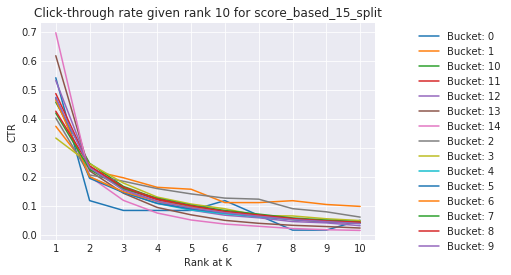

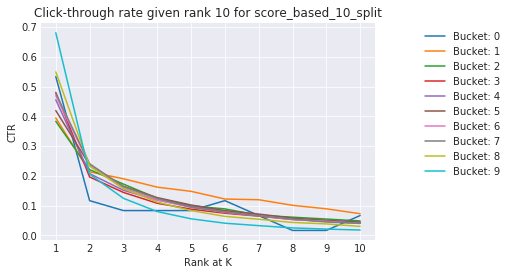

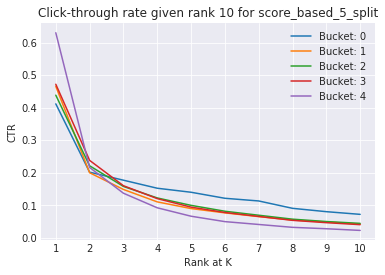

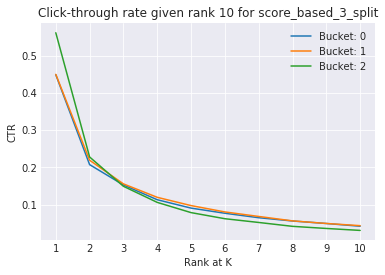

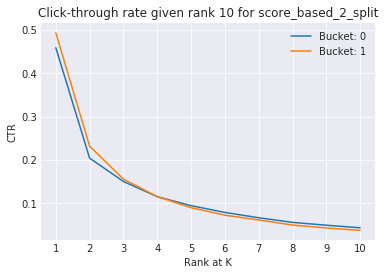

In [11]:
def plot_ctr_buckets(df, to_be_splitted: str, plot_to_rank: int):
    """
    to_be_splitted: 'even_size_bins'
                    'query_length'
                    'bucket_cat'
    :param df:
    :return:
    """

    for shape, df_group in df.groupby([to_be_splitted]):
        ctr = get_ctr(df_group)
        bucket_str = df_group.iloc[0][to_be_splitted]
        bucket_str = bucket_str.split('_')[1]
        plt.plot(np.arange(1,len(ctr[:plot_to_rank])+1), ctr[:plot_to_rank],  label='Bucket: {}'.format(bucket_str))

    plt.xlabel('Rank at K')
    plt.ylabel('CTR')
    plt.title("Click-through rate given rank {} for {}".format(plot_to_rank, to_be_splitted))
    plt.xticks(np.arange(1, plot_to_rank+1, step=1))

    if to_be_splitted == 'score_based_15_split' or to_be_splitted == 'score_based_10_split':
        plt.legend(bbox_to_anchor=(1.40,1))
        plt.show()
    else:
        plt.legend()
        plt.show()    

    
plot_ctr_buckets(df, to_be_splitted='score_based_15_split',plot_to_rank=10)
plot_ctr_buckets(df, to_be_splitted='score_based_10_split',plot_to_rank=10)
plot_ctr_buckets(df, to_be_splitted='score_based_5_split' ,plot_to_rank=10)
plot_ctr_buckets(df, to_be_splitted='score_based_3_split' ,plot_to_rank=10)
plot_ctr_buckets(df, to_be_splitted='score_based_2_split' ,plot_to_rank=10)
    


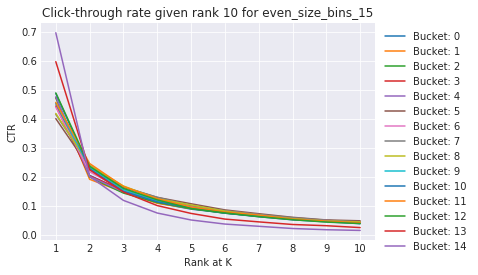

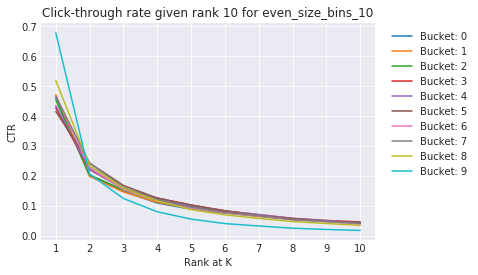

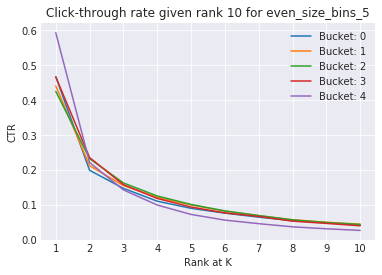

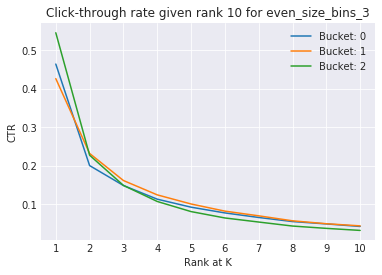

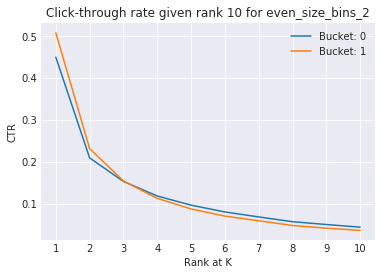

In [12]:
def plot_ctr_buckets(df, to_be_splitted: str, plot_to_rank: int):
    """
    to_be_splitted: 'even_size_bins'
                    'query_length'
                    'bucket_cat'
    :param df:
    :return:
    """

    for shape, df_group in df.groupby([to_be_splitted]):
        ctr = get_ctr(df_group)
        bucket_str = df_group.iloc[0][to_be_splitted]
        plt.plot(np.arange(1,len(ctr[:plot_to_rank])+1),ctr[:plot_to_rank],  label='Bucket: {}'.format(bucket_str))

    plt.xlabel('Rank at K')
    plt.ylabel('CTR')
    plt.title("Click-through rate given rank {} for {}".format(plot_to_rank, to_be_splitted))
    plt.xticks(np.arange(1, plot_to_rank+1, step=1))

    if to_be_splitted == 'even_size_bins_15' or to_be_splitted == 'even_size_bins_10':
        plt.legend(bbox_to_anchor=(1.30,1))
        plt.show()
    else:
        plt.legend()
        plt.show() 
    

    
plot_ctr_buckets(df, to_be_splitted='even_size_bins_15',plot_to_rank=10)
plot_ctr_buckets(df, to_be_splitted='even_size_bins_10',plot_to_rank=10)
plot_ctr_buckets(df, to_be_splitted='even_size_bins_5',plot_to_rank=10)
plot_ctr_buckets(df, to_be_splitted='even_size_bins_3',plot_to_rank=10)
plot_ctr_buckets(df, to_be_splitted='even_size_bins_2',plot_to_rank=10)


    


In [13]:
from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4,cluster_std=0.60, random_state=0)
X.shape
# plt.scatter(X[:, 0], X[:, 1], s=50);

(300, 2)

HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

(423674, 3)

Text(0.5,0,'query_length')

Text(0,0.5,'idf_query_score')

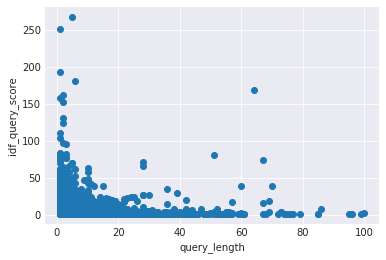

In [7]:

df =  pd.read_hdf('./data/df_27_aggregated')
df['query_length'] = df['SearchText_norm'].progress_apply(lambda x:  len(x))
df['#_of_clicks'] = df['DocumentPositions'].progress_apply(lambda x: len(x))

X = np.array([df['query_length'].tolist(), df['idf_query_score'].tolist(), df['#_of_clicks'].tolist()])
X = X.reshape((423674,3))
X.shape

# Mask outliers 
X = X[X[:, 0] <= 100]


plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('query_length')
plt.ylabel('idf_query_score')
plt.show()


In [8]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Text(0.5,0,'query_length')

Text(0,0.5,'idf_query_score')

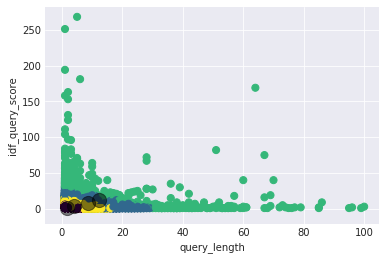

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('query_length')
plt.ylabel('idf_query_score')
plt.show()

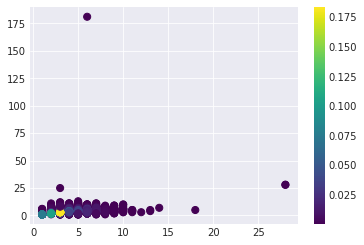

In [10]:
from scipy.stats import gaussian_kde

length = 10000
x, y = X[:, 0][:length], X[:, 1][:length]

xy = np.vstack([x,y])
color = gaussian_kde(xy)(xy)


plt.scatter(x, y, c=color, s=50, cmap='viridis')
plt.colorbar()

<IPython.core.display.Javascript object>


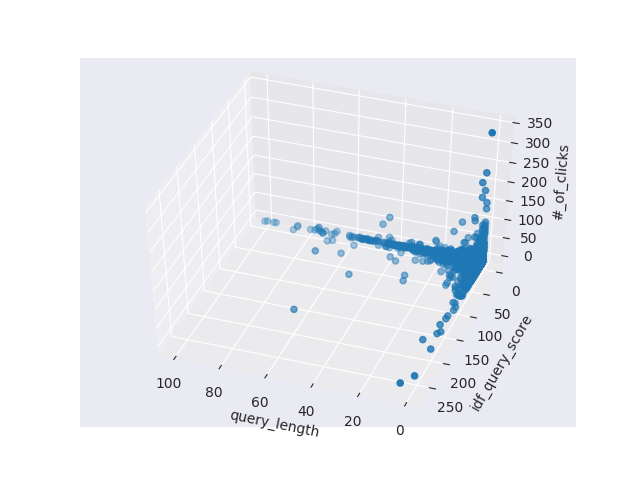

Text(0.5,0,'query_length')

Text(0.5,0,'idf_query_score')

Text(0.5,0,'#_of_clicks')

In [12]:
%matplotlib notebook
from mpl_toolkits import mplot3d

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection="3d")

# z_points = 15 * np.random.random(100)
# x_points = np.cos(z_points) + 0.1 * np.random.randn(100)
# y_points = np.sin(z_points) + 0.1 * np.random.randn(100)


# ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');
ax.set_xlabel('query_length')
ax.set_ylabel('idf_query_score')
ax.set_zlabel('#_of_clicks')
# X.shape
ax.scatter3D(X[:, 0], X[:, 1],X[:, 2], cmap='hsv');


plt.show()

In [ ]:
df['#_of_clicks'] = df['DocumentPositions'].progress_apply(lambda x: len(x))

X = np.array([df['query_length'].tolist(), df['idf_query_score'].tolist(), df['#_of_clicks'].tolist()])
X = X.reshape((423674,3))
X.shape


kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [ ]:

fig = plt.figure()
ax = plt.axes(projection="3d")

# df['query_length'].tolist(), df['idf_query_score'].tolist(), df['#_of_clicks'].tolist()])

# z_points = 15 * np.random.random(100)
# x_points = np.cos(z_points) + 0.1 * np.random.randn(100)
# y_points = np.sin(z_points) + 0.1 * np.random.randn(100)


# ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

X.shape
ax.scatter3D(X[:, 0], X[:, 1],X[:, 2], c=y_kmeans, cmap='viridis');
ax.set_xlabel('query_length')
ax.set_ylabel('idf_query_score')
ax.set_zlabel('#_of_clicks')
plt.title('3 Means clustering on three dimensions')

plt.show()

In [4]:
def list_checker(x):
    if isinstance(x, list):
        return x
    else:
        return [x]
    

In [5]:
def request_documents_title(doc_id) -> pd.DataFrame :
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-18-184-94-154.eu-central-1.compute.amazonaws.com:8080/solr' \
     '/ACC_Legal_Slave/select?indent=on&q=ID:{}&wt=json'.format(doc_id)
    
    
    try:
        response = requests.get(url)

        # Transform the request into a json
        response = response.json()
        response = response['response']['docs'][:]

        df =  pd.DataFrame(response)

        date = df['PublicationDate']
        secondary_title = df['SecondaryTitle']

    except:
        date = "Exception"
        secondary_title = "Exception"

    return date, secondary_title


def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    

def run():
    """
    Start extracting titles and dates from the Document ID's
    :param df: 
    """
    df = pd.read_hdf('./data/df_27_aggregated')

    df['DocumentIDs'] = df['DocumentIDs'].progress_apply(lambda x: list_checker(x))
    doc_ids = df['DocumentIDs'].tolist()

    all_dates = []
    all_titles = []
    from_id = 0
    
    for idx, doc_id_list in enumerate(tqdm(doc_ids, desc='Looping through doc ids')):
        dummy_dates = []
        dummy_titles = []
        
        for doc_id in doc_id_list:

            date, secondary_title = request_documents_title(doc_id)
            
            dummy_dates.extend(date)
            dummy_titles.extend(secondary_title)
            
        all_dates.append(dummy_dates)
        all_titles.append(dummy_titles)

        if idx % 20000 == 0 and idx != 0:
            
            save_obj(all_dates, './data/solr/date/dates_{}_until_{}.txt'.format(from_id, idx))
            save_obj(all_titles, './data/solr/snippet/snippet_{}_until_{}.txt'.format(from_id, idx))
            all_dates = []
            all_titles = []
            from_id = idx
            
        if idx == len(doc_ids):
            save_obj(all_dates, './data/solr/date/dates_{}_until_{}.txt'.format(from_id, idx))
            save_obj(all_titles, './data/solr/snippet/snippet_{}_until_{}.txt'.format(from_id, idx))
            all_dates = []
            all_titles = []
            from_id = idx
        
        
    return 

# os.listdir()
# os.getcwd()
run()

HBox(children=(IntProgress(value=0, max=423674), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through doc ids', max=423674, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [14]:
# df = pd.read_hdf(path_or_buf='./data/df_27_aggregated')
# df
os.listdir('./data/')
os.getcwd()


dates = load_obj('/home/winston/PycharmProjects/LegalInteligenceTFIDF/data/solr/date/dates_0_until_20000.txt')


['idf_dict.pkl',
 'click_through_rate_rank15.jpeg',
 'df_27',
 'stopwords_nl.txt',
 'click_through_rate_rank50.jpeg',
 'AOL_search_data_leak_2006.zip',
 'data.txt',
 'AOL-user-ct-collection',
 '.~lock.search_text_6_10.xlsx#',
 'solr_dump.txt',
 'click_through_rate_rank10.jpeg',
 'search_text_6_10.xlsx',
 'df_agg',
 'titles.txt',
 'click_through_rate_rank5.jpeg',
 'solr',
 'df_27_aggregated']

'/home/winston/PycharmProjects/LegalInteligenceTFIDF'

In [17]:
dates[:20]
df[:20]

[[20190715, 20190514],
 [20190707],
 [20190617],
 [20190623],
 [20190623],
 [20190707, 20190707, 20190707],
 [20190520],
 [20190324],
 [20190602, 20190602],
 [20190610, 20190630],
 [20190729],
 [20190715],
 [20190310, 20190114],
 [20190630],
 [20190617],
 [20190519],
 [20190624],
 [20190519],
 [20190623],
 [20190506]]

,UserID,DocumentIDs,DocumentPositions,DocumentURLs,EventID,ID,SearchTypeID,ShortTimeStamp,SearchText,SearchText_norm,idf_query_score,query_length,score_based_2_split,score_based_3_split,score_based_5_split,score_based_7_split,score_based_10_split,score_based_15_split,score_based_18_split,even_size_bins_2,even_size_bins_3,even_size_bins_5,even_size_bins_7,even_size_bins_10,even_size_bins_15
7193,11028,"[32295235, 31998893]","[1, 11]",[https://www.navigator.nl/#/document/id4aee20c...,27,a9e0d162-42f1-4785-9d8c-3daef31915da,14,20190809,NJ,[nj],3.766668,1,0,0,0,0,0,0,0,0,0,0,0,0,0
20091,24639,32246565,[6],https://www.navigator.nl/#/document/id292e754a...,27,ad64390a-887a-4c43-82e3-30be17118109,14,20190722,nj,[nj],3.766668,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19971,24639,32133620,[12],https://www.navigator.nl/#/document/id2462c20d...,27,508e1b9b-2bf9-4dd3-aa0a-a989a841d9b9,14,20190702,nj,[nj],3.766668,1,0,0,0,0,0,0,0,0,0,0,0,0,0
288240,201539,32159295,[1],https://www.navigator.nl/#/document/id97153aa3...,27,507044b9-1efc-481c-a0c4-82a4b6e1dbf2,14,20190628,NJ,[nj],3.766668,1,0,0,0,0,0,0,0,0,0,0,0,0,0
288242,201539,32159295,[1],https://www.navigator.nl/#/document/id97153aa3...,27,a136c29e-2387-4acc-beba-6b40a6189c9e,14,20190701,NJ,[nj],3.766668,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7174,11028,32042313,[2],https://www.navigator.nl/#/document/id17b81aa3...,27,8708afdc-63e1-429c-8a9d-cc1c1b8e8185,14,20190530,NJ,[nj],3.766668,1,0,0,0,0,0,0,0,0,0,0,0,0,0
386158,232049,32159299,[2],https://www.navigator.nl/#/document/idb9e92c49...,27,be1029dc-92df-4284-a900-545c33531c18,14,20190702,nj,[nj],3.766668,1,0,0,0,0,0,0,0,0,0,0,0,0,0
141352,124362,32042313,[2],https://www.navigator.nl/#/document/id17b81aa3...,27,8dfe7d5e-3322-491f-a323-8529605bd048,14,20190605,NJ,[nj],3.766668,1,0,0,0,0,0,0,0,0,0,0,0,0,0
160003,133959,32159276,[1],https://www.navigator.nl/#/document/id1f37a89f...,27,06e3fbe1-f25e-451d-8f47-169890b16290,14,20190711,NJ,[nj],3.766668,1,0,0,0,0,0,0,0,0,0,0,0,0,0


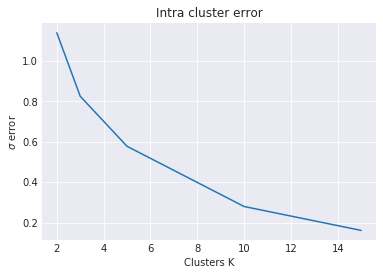

[(2, 1.139405838641354),
 (3, 0.8251921252432188),
 (5, 0.5774814718165555),
 (10, 0.2794457521333672),
 (15, 0.16108136911746798)]

In [132]:
def calculate_intra_cluster_error(df: pd.DataFrame):
    """
    Plot and find the average intra_cluster standard devation.
    :param df: dataframe containing clusters and scores
    """
    
    score_based = ['score_based_15_split', 'score_based_10_split',  'score_based_5_split',  'score_based_3_split',
                     'score_based_2_split']
    total_error = {}
    
    for to_be_splitted in score_based:     
        error_per_split = []
        for shape, df_group in df.groupby([to_be_splitted]):

            split_digit = re.findall(r"\d+", to_be_splitted)
            deviation = np.std(df_group['idf_query_score'])
            error_per_split.append(deviation)
        
        total_error.update({to_be_splitted : np.average(error_per_split)})
   

    total_error = {int(re.findall(r"\d+", key)[0]) : value for key,value in total_error.items()}
    total_error = sorted(total_error.items(), key = lambda x : x[1], reverse=True)
       
    x,y = zip(*total_error)
    plt.plot(x, y)
    plt.title('Intra cluster error')
    plt.ylabel('$\sigma$ error in idf query score')
    plt.xlabel('Clusters K')
    plt.show()
    
    return total_error


total = calculate_intra_cluster_error(df)
total


('score_based_2_split',
 'score_based_3_split',
 'score_based_5_split',
 'score_based_10_split',
 'score_based_15_split')

In [12]:
re.findall(r"\d+",'score_based_15_split')


['15']

In [37]:
A = {'score_based_15_split': 0.16108136911746798, 'score_based_10_split': 0.2794457521333672, 'score_based_5_split': 0.5774814718165555, 'score_based_3_split': 0.8251921252432188, 'score_based_2_split': 1.139405838641354}

In [38]:
A

{'score_based_10_split': 0.2794457521333672,
 'score_based_15_split': 0.16108136911746798,
 'score_based_2_split': 1.139405838641354,
 'score_based_3_split': 0.8251921252432188,
 'score_based_5_split': 0.5774814718165555}

In [63]:
[x for x in A.items()][0]

('score_based_15_split', 0.16108136911746798)

In [56]:
for i,j in A.items():
    print(i,j)

score_based_15_split 0.16108136911746798
score_based_10_split 0.2794457521333672
score_based_5_split 0.5774814718165555
score_based_3_split 0.8251921252432188
score_based_2_split 1.139405838641354


In [66]:
{value: key for key, value in A.items()}

{0.16108136911746798: 'score_based_15_split',
 0.2794457521333672: 'score_based_10_split',
 0.5774814718165555: 'score_based_5_split',
 0.8251921252432188: 'score_based_3_split',
 1.139405838641354: 'score_based_2_split'}

In [74]:
A.keys()


dict_keys(['score_based_15_split', 'score_based_10_split', 'score_based_5_split', 'score_based_3_split', 'score_based_2_split'])

In [81]:
total_error = sorted(A.items(), key= lambda x : x[1], reverse=True)


In [100]:
A = [('2', 1.139405838641354), ('3', 0.8251921252432188), ('5', 0.5774814718165555), ('10', 0.2794457521333672), ('15', 0.16108136911746798)]
A = dict(A)

In [101]:
A

{'10': 0.2794457521333672,
 '15': 0.16108136911746798,
 '2': 1.139405838641354,
 '3': 0.8251921252432188,
 '5': 0.5774814718165555}

In [135]:
df

len(np.unique(df['SearchText_norm']))

,UserID,DocumentIDs,DocumentPositions,DocumentURLs,EventID,ID,SearchTypeID,ShortTimeStamp,SearchText,SearchText_norm,idf_query_score,score_based_15_split,score_based_10_split,score_based_5_split,score_based_3_split,score_based_2_split,even_size_bins_15,even_size_bins_10,even_size_bins_5,even_size_bins_3,even_size_bins_2
7193,11028,"[32295235, 31998893]","[1, 11]",[https://www.navigator.nl/#/document/id4aee20c...,27,a9e0d162-42f1-4785-9d8c-3daef31915da,14,20190809,NJ,[nj],3.766668,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0
330158,219507,32119204,[1],https://www.navigator.nl/#/document/id93749ed4...,27,6ce4d6c9-ef17-4aa9-9029-013ee66b10ed,14,20190620,nj,[nj],3.766668,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0
19040,23955,"[32393522, 3794163]","[1, 3]",[https://www.navigator.nl/#/document/id47d2565...,27,273cae6d-b0fd-4551-b922-724e16cb866c,14,20190821,nj,[nj],3.766668,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0
262712,189733,14980884,[4],https://www.navigator.nl/#/document/id72c033ff...,27,6f3cb0f2-fc85-472e-a435-ee6e2b78601d,14,20190614,nj,[nj],3.766668,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0
288258,201539,32295235,[1],https://www.navigator.nl/#/document/id4aee20cc...,27,a9526c06-228a-4c1d-a078-6f57afbd0320,14,20190723,NJ,[nj],3.766668,bucket_0,bucket_0,bucket_0,bucket_0,bucket_0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262563,189582,184877,[1],http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,69f52117-1512-431b-8879-f243405bcf1d,14,20190628,ECLI:NL:GHARN:2003:AF3460,[eclinlgharn2003af3460],14.018768,bucket_14,bucket_9,bucket_4,bucket_2,bucket_1,14,9,4,2,1
226723,171538,30214041,[1],http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,955d5954-e934-473f-85b1-c34d7ffe8a1d,14,20190719,ECLI:NL:ghdha:2018:1681,[eclinlghdha20181681],14.018768,bucket_14,bucket_9,bucket_4,bucket_2,bucket_1,14,9,4,2,1
240835,179739,8301913,[1],http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,2b8b0ba1-97cf-4239-8d44-28b35cc3508d,14,20190709,ECLI:NL:RBONE:2013:BZ3464,[eclinlrbone2013bz3464],14.018768,bucket_14,bucket_9,bucket_4,bucket_2,bucket_1,14,9,4,2,1
118345,103253,12731297,[1],http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,7a3c104e-fe56-4260-a497-80a07a9547e1,14,20190705,201304275/1/A3,[2013042751a3],14.018768,bucket_14,bucket_9,bucket_4,bucket_2,bucket_1,14,9,4,2,1


319285

In [ ]:
text = np.loadtxt('./data/')